In [1]:
"""
CleanData.py
"""
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

"""pre data cleaning for reviews data"""
def clean_reviews(REVIEWS):
    REVIEWS = REVIEWS[~REVIEWS.quote.isnull()]
    REVIEWS = REVIEWS[REVIEWS.fresh != 'none']
    REVIEWS = REVIEWS[REVIEWS.quote.str.len() > 0]
    REVIEWS['review_date'] = pd.to_datetime(REVIEWS['review_date']).dt.date
    REVIEWS_CLEAN = REVIEWS.drop(['link'], axis=1)
    return REVIEWS_CLEAN

""" pre data cleaning for movies data"""
def clean_movies(MOVIES):
    MOVIES = MOVIES.drop(['imdbPictureURL', 'spanishTitle', 'rtPictureURL'], axis=1)
    MOVIES['rtAllCriticsRating'] = MOVIES['rtAllCriticsRating'].apply(pd.to_numeric, errors='drop')
    MOVIES['rtAllCriticsNumReviews'] = MOVIES['rtAllCriticsNumReviews'].apply(pd.to_numeric, errors='drop')
    MOVIES['rtAudienceRating'] = MOVIES['rtAudienceRating'].apply(pd.to_numeric, errors='drop')
    SUB_MOVIES = MOVIES[['title', 'imdbID', 'year', 'rtID', 'rtAllCriticsRating', 'rtAllCriticsNumReviews', 'rtAudienceNumRatings', 'rtAudienceScore']]
    return SUB_MOVIES

def merge_movies_reviews(REVIEWS,SUB_MOVIES):
    REVIEWS_MERGE = REVIEWS_CLEAN.merge(SUB_MOVIES, left_on='imdb', right_on='imdbID', how='left',suffixes=('_review', '_movie'))   
    return REVIEWS_MERGE



In [2]:
"""
OverallRating.py
"""
import pandas as pd
import altair as alt
from vega_datasets import data
import matplotlib.pyplot as plt
import mpld3
import webbrowser


def draw_trend_line_median_year(SUB_MOVIES,start_year,end_year):
    """
    Descripion:
    @param:
    @return:
    """
    
    year_median = SUB_MOVIES.groupby('year')['rtAllCriticsRating'].median().reset_index()
    year_show = year_median[year_median['year'] >= start_year]
    year_show = year_show[year_median['year'] <= end_year]

    selection = alt.selection_interval(bind='scales')

    chart_overall = alt.Chart(year_show).mark_line().encode(
    alt.Y('rtAllCriticsRating:Q',
        scale=alt.Scale(domain=(0, 10))
    ),
    x='year:N',
    tooltip=['rtAllCriticsRating:Q','year']).add_selection(selection).properties(
    width=500,
    height=200
    )
    
    chart_overall.save("overallchart.html")
    return chart_overall
    

def top5_critic_per_year(REVIEWS_MERGE,interest_year):
    """
    Descripion:
    @param:
    @return:
    """
    Group_Aggregation = REVIEWS_MERGE[['critic', 'publication', 
                       'year', 'quote']].groupby(['critic','year']).agg({ 
                         'quote': ['count']}).reset_index()
    
    Group_Aggregation = Group_Aggregation[(Group_Aggregation['year'] == interest_year)]
    Top_five = Group_Aggregation.sort_values(by=[('quote','count')], 
                                            ascending = False)[:5].reset_index(drop =True)

    top_critics = list(Top_five['critic'])
    
    
    
    return top_critics
    return REVIEWS_MERGE

In [3]:
"""
SentimentAnalysis.py
"""

import pandas as pd
import sentiments_nrc
import re
from sentiments_nrc import SENTIMENTS
from sentiments_nrc import EMOTIONS

MOVIES = pd.read_csv("../data/movies.dat", delimiter='\t')
REVIEWS = pd.read_csv('../data/reviews.csv')

EMOTIONS = ['positive', 'negative', 'anger', 
            'anticipation', 'disgust', 'fear', 
            'joy', 'sadness', 'surprise', 'trust']

def grab_quotes(REVIEWS_MERGE,top_critics,interest_year):
    quote = pd.DataFrame()
    for name in top_critics:
        critic_quote = REVIEWS_MERGE[['critic','quote','year']]
        sub_quote = critic_quote[(critic_quote['critic'] == name) & (critic_quote['year'] == interest_year)]
    #   print(len(sub_quote))
        quote = quote.append(sub_quote,ignore_index=True)
        quote = quote.groupby('critic')['quote'].apply(' '.join).reset_index()
    return quote
    
def analyze_quote(quote,top_critics):
    res = pd.DataFrame()
    for name in top_critics:
        content = quote[quote['critic'] == name]['quote'].values[0]
#         content=quote.groupby('critic')['quote'].apply(' '.join).reset_index()['quote']
        Split_String=re.split(r'\W+',content) 
        lower_words=[word.lower() for word in Split_String] 
        length_filtered=[word for word in lower_words if len(word)>1]
    
    ### calculate total number or words
        Total_Words=len(length_filtered)
        Words_List_for_Each_Emotion=words_list_for_each_emotion(length_filtered)
    
        result_list=[]
        for i in EMOTIONS:
            result={}
            example_words=[get_common_words_list(value)[:3] for key,value in Words_List_for_Each_Emotion.items() if key==i]
            result['EMOTION']=i
            result['PERCENT']= len(Words_List_for_Each_Emotion[i])/Total_Words
            result['EXAMPLE WORDS']=example_words[0]
            result['name'] = name
            result_list.append(result)
            result=sorted(result_list,key=lambda k:k['PERCENT'],reverse=True)
            result = pd.DataFrame(result)
            res = res.append(result)

    return res

In [4]:
"""
SentimentSetup.py
"""
# support function 1
def words_with_specific_emotion(list_of_split_words,emotion):
    '''Produce a list that include the words that contain a specific emotion
       Parameters: list_of_split_words (String): A list with split words 
                   emotion(string): the emotion words in EMOTIONS list
       Returns: list: the words in the string with one certain kind of emotion'''
    Look_Up=[SENTIMENTS.get(word) for word in list_of_split_words] #get the emotion list of every word in the list 
    Combine=list(zip(list_of_split_words,Look_Up)) # zip the emotion list with word in one list 
    Words_With_Specific_Emotion=[line[0] for line in Combine if line[1] is not None and line[1].get(emotion)==1 ]
    return Words_With_Specific_Emotion #find the words in a specific emotion

# support function 2
def words_list_for_each_emotion(Split_Test_String):
    '''Produce a disctionary with emotion words as keys and words list having that emotion as values
       Parameters: Split_Test_String (String): A list with split words
       Returns: list-the  most common words in the input list'''
    matching_words=[words_with_specific_emotion(Split_Test_String,emotion) for emotion in EMOTIONS]
    distinct_matching=[i for i in matching_words]
    return {emotion:matching_word for (emotion,matching_word) in zip(EMOTIONS,distinct_matching)}

# support function 3 
def get_common_words_list(wordlist):
    '''Produce a list with the most common words of the input list
       Parameters: wordlist (string): 
       Returns: dict: the key-values pairs of emotions word and its corresponding words in the string'''
    wordfreq=list(zip(wordlist,[wordlist.count(w) for w in wordlist]))
    wordfreq_sort=list(set(sorted(wordfreq,key=lambda freq: freq[1], reverse=True)))
    new_word_freq_sort=sorted(wordfreq_sort,key=lambda freq: freq[1], reverse=True)
    return [i[0] for i in new_word_freq_sort]

In [5]:
"""
Visualization.py
"""
def visualize(EMOTION_ARRAY):
    import altair as alt
    alt.renderers.enable('notebook')

    input_dropdown = alt.binding_select(options=EMOTIONS)
    selection = alt.selection_single(fields=['name'], bind=input_dropdown, name='Emotion of ')
    #color = alt.condition(selection,
                        #alt.Color('critic:N', legend=None),
                        #alt.value('lightgray'))
    chart_final = alt.Chart(EMOTION_ARRAY).mark_bar().encode(
         x='PERCENT:Q',
         y=alt.Y(
            'EMOTION:N',
            sort=alt.EncodingSortField(field='PERCENT', op='count', order='ascending')
            ),
        facet='name:N',
        color='EMOTION:N',
        tooltip='PERCENT:Q',
        ).properties(
        width=150,
        height=150,
        title = 'Sentiment for Top 5 Critics',
        columns=5,
        ).transform_filter(
    selection)
    chart_final.save('finalchart.html')



In [17]:
EMOTION_ARRAY = analyze_quote(QUOTES,top_critics)

In [30]:
def visualize(EMOTION_ARRAY):
    import altair as alt
    alt.renderers.enable('notebook')

    input_dropdown = alt.binding_select(options=EMOTIONS)
    selection = alt.selection_single(fields=['EMOTION'], bind=input_dropdown, name ='Type of')
    color = alt.condition(selection,
                        alt.Color('EMOTION:N', legend=None),
                        alt.value('lightgray'))
    chart_final = alt.Chart(EMOTION_ARRAY).mark_bar().encode(
         x='PERCENT:Q',
         y=alt.Y(
            'EMOTION:N',
            sort=alt.EncodingSortField(field='PERCENT', op='count', order='ascending')
            ),
        facet='name:N',
        color= color,
        tooltip='PERCENT:Q',
        ).properties(
        width=150,
        height=150,
        title = 'Sentiment for Top 5 Critics',
        columns=5,
        ).add_selection(
    selection)
#     .transform_filter(
#     selection).interactive()
    

    
    return chart_final
#     chart_final.save('finalchart.html')


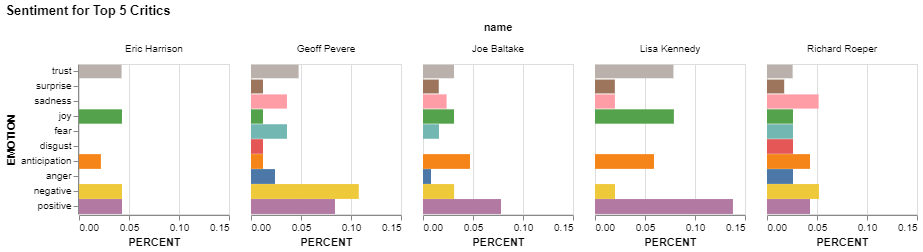

In [31]:
visualize(EMOTION_ARRAY)

"Tries to be both funny and touching and and isn't enough of either. Muddled and largely unentertaining. A Dead Poets Society for girls, substituting Roberts' luminosity for Robin Williams' mania. The kind of movie that sticks with you for days, your admiration growing each time you remember it."

In [ ]:
# pip install wordcloud
# nltk.download('stopwords')

In [46]:
# def transform_format(val):
#     if val.any() == 241:
#         return 255
#     else:
#         return val

# transformed_wine_mask = np.ndarray((wine_mask.shape[0],wine_mask.shape[1]), np.int32)

# for i in range(len(wine_mask)):
#     transformed_wine_mask[i] = list(map(transform_format, wine_mask[i]))

In [43]:
# wine_mask = np.array(Image.open("movie-review.jpg"))
# # mask 

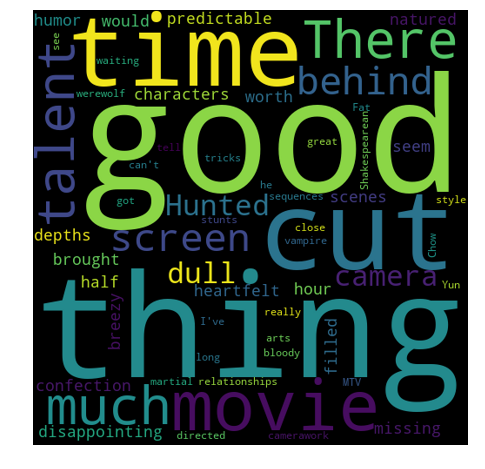

In [48]:
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
import numpy as np
from PIL import Image
def vis_word_cloud(QUOTES):
#     mask = np.array(Image.open("movie-review.jpg"))
    stop_words = stopwords.words("english")
    for i in range(len(QUOTES)):
        string = ''.join(QUOTES['quote'][i])
    wordcloud = WordCloud(width=500, height=500,
#     mask = mask,
    stopwords=stop_words, 
    min_font_size=10).generate(string)
        
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud, interpolation='catrom')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()


QUOTES = grab_quotes(REVIEWS_MERGE,top_critics,interest_year)
string = QUOTES['quote'][0]    
vis_word_cloud(QUOTES)  

In [8]:
'''LOAD DATA'''
MOVIES = pd.read_csv("../data/movies.dat", delimiter='\t')
REVIEWS = pd.read_csv('../data/reviews.csv')

'''OVERALL LOOK'''
start_year = 1990
end_year = 2013
SUB_MOVIES = clean_movies(MOVIES)
draw_trend_line_median_year(SUB_MOVIES,start_year,end_year)

'''CLEAN AND MERGE DATA'''
REVIEWS_CLEAN = clean_reviews(REVIEWS)
REVIEWS_MERGE = merge_movies_reviews(REVIEWS,SUB_MOVIES)

'''TOP CRITICS IN YEAR OF INTEREST'''
print('Please input a year of interest to see critic activity that year: ')
interest_year = int(input())
top_critics = top5_critic_per_year(REVIEWS_MERGE,interest_year)
print(top_critics)

'''GRAB CRITIC REVIEWS'''
QUOTES = grab_quotes(REVIEWS_MERGE,top_critics,interest_year)
print(QUOTES)

# '''ANALYZE QUOTES'''
# EMOTION_ARRAY = analyze_quote(QUOTES,top_critics)
# visualize(EMOTION_ARRAY)

Please input a year of interest to see critic activity that year: 
2003
['Joe Baltake', 'Geoff Pevere', 'Lisa Kennedy', 'Richard Roeper', 'Eric Harrison']
           critic                                              quote
0   Eric Harrison  Tries to be both funny and touching and and is...
1    Geoff Pevere  Friedkin is in his element. There's a terrific...
2     Joe Baltake  A thoroughly mediocre action movie. The movie ...
3    Lisa Kennedy  A lovely romp. For all Wonderland's kinetic en...
4  Richard Roeper  There's too much talent on-screen and behind t...


## 